In [1]:
import copy
import time, importlib
import h5py
import numpy as np
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import kalepy as kale

In [3]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects

In [4]:
import palettable

In [41]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.config as l_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting

In [7]:
import coolingFunction

In [8]:
import trove
import verdict
from py2tex import py2tex

In [9]:
%matplotlib inline

# Parameters

In [10]:
pm = dict(
    snum = 600,
    ahf_index = 600,
)

In [11]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.8',
    variation = 'm12i_md',
    global_variation = 'track_all_thin_disk_stars',
    **pm
)

In [12]:
snum = pm['snum']
sim_name = pm['variation']

In [13]:
print( sim_name, pm['global_variation'] )

m12i_md track_all_thin_disk_stars


# Load Data

In [14]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dirs']['jug.4'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [15]:
w.data_dir

'/scratch/03057/zhafen/hot_accretion_data/more_variations/track_all_thin_disk_stars/m12i_md'

In [16]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_fp, create_nonexistent=True )

In [17]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

# Analyze

## Calculate Central Indices

In [39]:
calc_fn = getattr( w, 'calc_{}'.format( pm['central_indices'] ) )
inds = calc_fn(
    lookback_time_max = pm['lookback_time_max'],
    choose_first = pm['choose_first'],
)
valid = inds!=-99999
valid_inds = inds[valid]
particle_inds = np.arange( w.n_particles )[valid]

100%|██████████| 100000/100000 [00:02<00:00, 43158.16it/s]


In [19]:
t_tchange_key = pm['central_indices'].split( '_' )[0]
tchange = w.get_data( t_tchange_key )

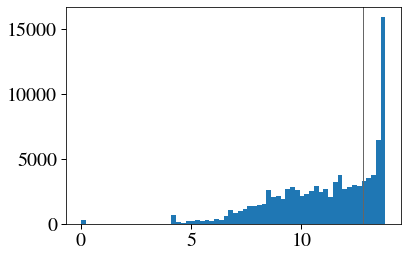

In [20]:
fig = plt.figure()
ax = plt.gca()

_ = ax.hist(
    tchange,
    bins = 64,
)

ax.axvline(
    w.get_data( 'time' )[0] - 1.,
    color = pm['background_linecolor'],
    linewidth = 1,
)

In [21]:
tot_momentum_fp = os.path.join( base_processed_data_dir, 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]
tot_ang_momentum_normed = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )
w.total_ang_momentum = tot_ang_momentum_normed

In [24]:
w.get_data( 'Jz/Jcirc' )

array([[0.94345598, 0.94946868, 0.9555146 , ...,        nan,        nan,
               nan],
       [0.85115127, 0.85787497, 0.86563276, ...,        nan,        nan,
               nan],
       [0.95870917, 0.62344337, 0.50070404, ...,        nan,        nan,
               nan],
       ...,
       [0.88747474, 0.89961881, 0.91427607, ...,        nan,        nan,
               nan],
       [0.92421697, 0.92739149, 0.93119211, ...,        nan,        nan,
               nan],
       [0.92602043, 0.93146551, 0.93740753, ...,        nan,        nan,
               nan]])

(array([2.688e+03, 5.362e+03, 5.400e+03, 5.494e+03, 5.726e+03, 5.781e+03,
        5.844e+03, 5.863e+03, 5.954e+03, 5.991e+03, 5.775e+03, 5.816e+03,
        5.695e+03, 5.432e+03, 5.169e+03, 4.766e+03, 4.403e+03, 3.742e+03,
        2.878e+03, 1.842e+03, 3.230e+02, 1.200e+01, 6.000e+00, 1.400e+01,
        5.000e+00, 6.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00]),
 array([0.79502138, 0.80499252, 0.81496366, 0.8249348 , 0.83490594,
        0.84487709, 0.85484823, 0.86481937, 0.87479051, 0.88476165,
        0.8947328 , 0.90470394, 0.91467508, 0.92464622, 0.93461736,
        0.9445885 , 0.95455965, 0.96453079, 0.97450193, 0.98447307,
        0.99444421, 1.00441536, 1.0143865 , 1.02435764, 1.03432878,
        1.04429992, 1.05427107, 1.06424221, 1.07421335, 1.08418449,
        1.09415563, 1.10412678, 1.11409792]),
 <BarContainer object of 32 artists>)

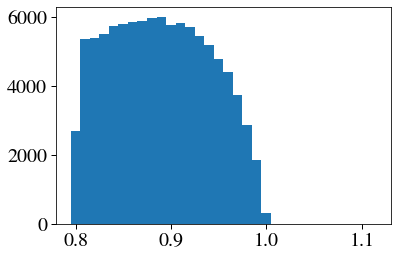

In [31]:
plt.hist(
    w.get_data( 'Jz/Jcirc' )[:,0],
    bins = 32,
)

(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 7.0000e+00,
        2.0000e+01, 7.5000e+01, 1.4600e+02, 2.2500e+02, 3.2100e+02,
        4.3800e+02, 5.9000e+02, 6.9800e+02, 8.6200e+02, 1.0120e+03,
        1.2340e+03, 1.6080e+03, 1.8200e+03, 2.1670e+03, 2.5870e+03,
        3.0350e+03, 3.8150e+03, 5.0250e+03, 6.9480e+03, 1.0592e+04,
        1.7715e+04, 3.9043e+04]),
 array([0.70247535, 0.71177299, 0.72107063, 0.73036827, 0.73966592,
        0.74896356, 0.7582612 , 0.76755885, 0.77685649, 0.78615413,
        0.79545177, 0.80474942, 0.81404706, 0.8233447 , 0.83264234,
        0.84193999, 0.85123763, 0.86053527, 0.86983291, 0.87913056,
        0.8884282 , 0.89772584, 0.90702348, 0.91632113, 0.92561877,
        0.93491641, 0.94421406, 0.9535117 , 0.96280934, 0.97210698,
        0.98140463, 0.99070227, 0.99999991]),
 <BarContainer object of 32 artists>)

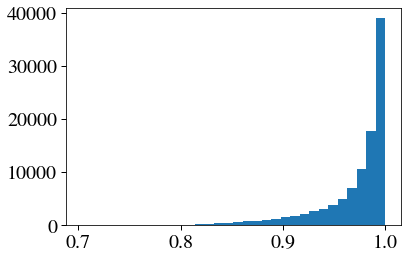

In [32]:
plt.hist(
    w.get_data( 'Jz/Jmag' )[:,0],
    bins = 32,
)

In [44]:
r_rolled = np.roll( w.get_data( 'R' )[particle_inds], valid_inds )

In [48]:
i = 0

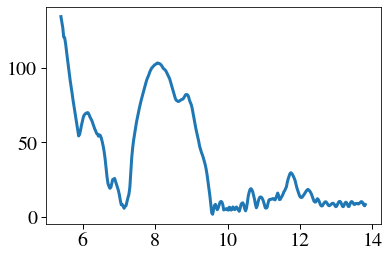

In [47]:

plt.plot(
    w.get_data( 'time' ),
    w.get_data( 'R' )[i],
)


